# Zomato Hackathon — Full Data Cleaning, Merging & Geospatial Visualization Notebook

## Step 1: Load Libraries & Dataset

In [3]:

import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster

# Load files
df = pd.read_csv('zomato_data.csv')
geo = pd.read_csv('Geographical Coordinates.csv')

df.head()


,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,approx_costfor_two_people,listed_intype,listed_incity
0,Yes,Yes,4.1/5,775,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Yes,No,4.1/5,787,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet,Banashankari
2,Yes,No,3.8/5,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,No,No,3.7/5,88,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet,Banashankari
4,No,No,3.8/5,166,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet,Banashankari


## Step 2: Clean Rating Column

In [5]:

df['rate'] = df['rate'].replace('-', np.nan)
df['rate'] = df['rate'].astype(str).str.replace('/5','', regex=False)
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')
df['rate'] = df['rate'].fillna(df['rate'].median())
df['rate'].head()


0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

## Step 3: Clean Cost Column

In [7]:

df['approx_costfor_two_people'] = (
    df['approx_costfor_two_people']
    .astype(str)
    .str.replace(',', '')
)

df['approx_costfor_two_people'] = pd.to_numeric(df['approx_costfor_two_people'], errors='coerce')
df['approx_costfor_two_people'] = df['approx_costfor_two_people'].fillna(df['approx_costfor_two_people'].median())
df['approx_costfor_two_people'] = df['approx_costfor_two_people'].astype(int)


## Step 4: Fill Missing Values in Categorical Columns

In [9]:

df['dish_liked'] = df['dish_liked'].fillna("Not Available")
df['cuisines'] = df['cuisines'].fillna("Other")
df['rest_type'] = df['rest_type'].fillna("Unknown")


## Step 5: Clean Votes Column

In [11]:

df['votes'] = pd.to_numeric(df['votes'], errors='coerce')
df['votes'] = df['votes'].fillna(df['votes'].median())
df['votes'] = df['votes'].astype(int)


## Step 6: Encode Binary Columns

In [13]:

df['online_order'] = df['online_order'].map({'Yes':1,'No':0})
df['book_table'] = df['book_table'].map({'Yes':1,'No':0})


## Step 7: Merge with Geographic Coordinates

In [15]:

merged_df = pd.merge(df, geo, on='listed_incity', how='left')
merged_df.head()


,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,approx_costfor_two_people,listed_intype,listed_incity,Latitude,Longitude
0,1,1,4.1,775,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet,Banashankari,12.939333,77.553982
1,1,0,4.1,787,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet,Banashankari,12.939333,77.553982
2,1,0,3.8,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet,Banashankari,12.939333,77.553982
3,0,0,3.7,88,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet,Banashankari,12.939333,77.553982
4,0,0,3.8,166,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet,Banashankari,12.939333,77.553982


## Step 8: Restaurant Density Map

In [19]:

m = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

coords = merged_df[['Latitude', 'Longitude']].dropna().values.tolist()

HeatMap(coords, radius=8).add_to(m)

m.save('restaurant_density_map.html')


## Step 9: Italian Restaurants Map

In [25]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# Use your merged dataframe
df = merged_df.copy()

# Filter Italian restaurants
italian_df = df[df['cuisines'].str.contains('Italian', case=False, na=False)]

# Prepare map
m = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

# Add marker cluster
marker_cluster = MarkerCluster().add_to(m)

# --- CREATE HTML FILTER UI ---
filter_html = """
<div style="
     position: fixed; 
     top: 10px; left: 50px; z-index: 9999; 
     background: white; padding: 15px; 
     border-radius: 10px; 
     box-shadow: 0 0 10px rgba(0,0,0,0.3);
     width: 250px;
">
<h4>Filters</h4>

<label>Rating:</label>
<select id="ratingFilter">
  <option value="all">All</option>
  <option value="4plus">4.0+</option>
  <option value="35plus">3.5+</option>
  <option value="3plus">3.0+</option>
</select>
<br><br>

<label>Cost for Two:</label>
<select id="costFilter">
  <option value="all">All</option>
  <option value="low">Below 400</option>
  <option value="mid">400 - 800</option>
  <option value="high">800+</option>
</select>
<br><br>

<label>Votes Above:</label>
<select id="votesFilter">
  <option value="all">All</option>
  <option value="100">100+</option>
  <option value="300">300+</option>
  <option value="500">500+</option>
</select>
<br><br>

<label>Locality:</label>
<select id="localFilter">
  <option value="all">All</option>
"""

# Add locality options
localities = italian_df['listed_incity'].dropna().unique()
for loc in sorted(localities):
    filter_html += f'<option value="{loc}">{loc}</option>'

filter_html += """
</select>

</div>

<script>
function applyFilters() {
    let rating = document.getElementById('ratingFilter').value;
    let cost = document.getElementById('costFilter').value;
    let votes = document.getElementById('votesFilter').value;
    let locality = document.getElementById('localFilter').value;

    for (let i in markers) {
        let m = markers[i];

        let rate = parseFloat(m.options.rate);
        let c = parseFloat(m.options.cost);
        let v = parseFloat(m.options.votes);
        let loc = m.options.locality;

        let show = true;

        if (rating === '4plus' && rate < 4) show = false;
        if (rating === '35plus' && rate < 3.5) show = false;
        if (rating === '3plus' && rate < 3) show = false;

        if (cost === 'low' && c >= 400) show = false;
        if (cost === 'mid' && (c < 400 || c > 800)) show = false;
        if (cost === 'high' && c <= 800) show = false;

        if (votes !== 'all' && v < parseFloat(votes)) show = false;

        if (locality !== 'all' && loc !== locality) show = false;

        if (show) {
            m.addTo(marker_cluster_group);
        } else {
            marker_cluster_group.removeLayer(m);
        }
    }
}

document.getElementById('ratingFilter').onchange = applyFilters;
document.getElementById('costFilter').onchange = applyFilters;
document.getElementById('votesFilter').onchange = applyFilters;
document.getElementById('localFilter').onchange = applyFilters;

</script>
"""

# Add UI to map
from folium import Element
m.get_root().html.add_child(Element(filter_html))

# --- ADD MARKERS ---

# JS holder array for filtering
m.get_root().script.add_child(Element("var markers = []; var marker_cluster_group = marker_cluster;"))

for _, row in italian_df.dropna(subset=['Latitude','Longitude']).iterrows():

    popup_text = f"""
    <b>Italian Restaurant</b><br>
    Cuisines: {row['cuisines']}<br>
    Rating: {row['rate']}<br>
    Votes: {row['votes']}<br>
    Cost for Two: ₹{row['approx_costfor_two_people']}<br>
    Locality: {row['listed_incity']}
    """

    marker = folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text
    )

    # Add JS filter attributes to marker
    marker.add_to(marker_cluster)
    id_js = f"""
        markers.push(
            L.marker([{row['Latitude']}, {row['Longitude']}], {{
                rate: "{row['rate']}",
                cost: "{row['approx_costfor_two_people']}",
                votes: "{row['votes']}",
                locality: "{row['listed_incity']}"
            }}).bindPopup(`{popup_text}`)
        );
    """
    m.get_root().script.add_child(Element(id_js))

# Save map
m.save("italian_restaurants_filtered_map.html")
print("✔ Italian Restaurant Filter Map Generated!")


✔ Italian Restaurant Filter Map Generated!


### Shape of the dataset

In [27]:
df.shape

(51717, 12)

### Restaurants serving North Indian cuisine

In [34]:
north_count = df[df['cuisines'].str.contains('North Indian', case=False, na=False)].shape[0]
north_count

21085

### Most commonly offered cuisine

In [37]:
from collections import Counter

all_cuis = []
for x in df['cuisines'].dropna():
    all_cuis += [c.strip() for c in x.split(',')]

Counter(all_cuis).most_common(1)[0]


('North Indian', 21085)

### Locality with highest average cost for two

In [40]:
df.groupby('listed_incity')['approx_costfor_two_people']\
  .mean().sort_values(ascending=False).head(1)


listed_incity
Church Street    770.361248
Name: approx_costfor_two_people, dtype: float64

### Top-rated restaurant type with >1000 votes

In [43]:
df[df['votes'] > 1000]\
  .groupby('rest_type')['rate']\
  .mean().sort_values(ascending=False).head(1)


rest_type
Bakery    4.8
Name: rate, dtype: float64

### Minimum cost for two in Bangalore

In [46]:
df['approx_costfor_two_people'].min()

40

### Percentage of online orders from Banashankari

In [49]:
total_online = df['online_order'].sum()
ban_online = df[df['listed_incity']=='Banashankari']['online_order'].sum()

percentage_online = (ban_online / total_online) * 100
percentage_online


1.7934568387859677

### Locality with >500 votes and rating < 3.0

In [52]:
tmp = df[(df['votes'] > 500) & (df['rate'] < 3.0)]
tmp['listed_incity'].value_counts().head(1)


listed_incity
Brookefield    8
Name: count, dtype: int64

### Locality with highest restaurant-type diversity

In [55]:
df.groupby('listed_incity')['rest_type']\
  .nunique().sort_values(ascending=False).head(1)

listed_incity
BTM    62
Name: rest_type, dtype: int64

### Average cost difference – buffet vs delivery

In [58]:
buffet_cost = df[df['listed_intype'].str.contains('Buffet', na=False)]['approx_costfor_two_people'].mean()
delivery_cost = df[df['listed_intype'].str.contains('Delivery', na=False)]['approx_costfor_two_people'].mean()

buffet_cost - delivery_cost


831.2513659898209

### Max votes among restaurants with online ordering

In [61]:
df[df['online_order'] == 1]['votes'].max()

16832

### Avg rating for restaurants serving BOTH North Indian & Chinese

In [64]:
dual = df[
    df['cuisines'].str.contains('North Indian', case=False, na=False) &
    df['cuisines'].str.contains('Chinese', case=False, na=False)
]

dual['rate'].mean()


3.5919080217658412

### Most profitable area (revenue proxy = cost × votes)

In [67]:
df['revenue_proxy'] = df['approx_costfor_two_people'] * df['votes']
df.groupby('listed_incity')['revenue_proxy']\
  .mean().sort_values(ascending=False).head(1)


listed_incity
MG Road    511854.925456
Name: revenue_proxy, dtype: float64

### Restaurant type with lowest rating (high complaints)

In [70]:
df.groupby('rest_type')['rate']\
  .mean().sort_values().head(1)


rest_type
Dessert Parlor, Kiosk    3.0
Name: rate, dtype: float64

### Best area with: rating > 4.2, votes > 500, online ordering

In [73]:
filtered = df[(df['rate'] > 4.2) &
              (df['votes'] > 500) &
              (df['online_order'] == 1)]

filtered['listed_incity'].value_counts().head(1)


listed_incity
Koramangala 7th Block    97
Name: count, dtype: int64

### How much does it cost at minimum to eat out in Bangalore?

In [76]:
df['approx_costfor_two_people'].min()


40

### Which locality has the most restaurants with over 500 votes and a rating below 3.0?

In [79]:
tmp = df[(df['votes'] > 500) & (df['rate'] < 3.0)]
tmp['listed_incity'].value_counts().head(10)


listed_incity
Brookefield              8
Whitefield               6
Indiranagar              4
Old Airport Road         4
Bellandur                3
Marathahalli             3
Banashankari             2
Koramangala 4th Block    2
Koramangala 5th Block    2
Koramangala 6th Block    2
Name: count, dtype: int64

### Brookefield — Brookefield has 8 such restaurants (next: Whitefield 6).

### Which locality in Bangalore should Zomato target for expansion based on restaurant-type diversity?

In [82]:
df.groupby('listed_incity')['rest_type'].nunique().sort_values(ascending=False).head(10)


listed_incity
BTM                      62
Brigade Road             61
Church Street            61
MG Road                  59
Lavelle Road             59
Koramangala 6th Block    59
Koramangala 4th Block    59
Koramangala 7th Block    58
Koramangala 5th Block    58
Residency Road           57
Name: rest_type, dtype: int64

### BTM — BTM has the highest number of unique rest_type values (62).

### What is the most profitable area for Zomato based on potential revenue estimation?

In [87]:
df['revenue_proxy'] = df['approx_costfor_two_people'] * df['votes']
df.groupby('listed_incity')['revenue_proxy'].mean().sort_values(ascending=False).head(10)


listed_incity
MG Road                  511854.925456
Church Street            489954.772852
Indiranagar              472316.252688
Brigade Road             470557.501413
Residency Road           466947.663580
Old Airport Road         457948.764912
Lavelle Road             429129.423739
Koramangala 5th Block    348240.440762
Koramangala 6th Block    345430.556615
Koramangala 7th Block    342476.381892
Name: revenue_proxy, dtype: float64

### MG Road — MG Road has the highest mean revenue-proxy per locality.

### If Zomato wants to reduce customer complaints, which restaurant type should they focus on?

In [91]:
df.groupby('rest_type')['rate'].mean().sort_values(ascending=True).head(10)


rest_type
Dessert Parlor, Kiosk        3.000000
Bakery, Food Court           3.100000
Food Court, Casual Dining    3.240000
Bhojanalya                   3.266667
Quick Bites, Kiosk           3.300000
Quick Bites, Food Court      3.347368
Unknown                      3.398678
Quick Bites, Cafe            3.402439
Quick Bites, Mess            3.425000
Bakery, Quick Bites          3.461592
Name: rate, dtype: float64

### Dessert Parlor, Kiosk — This rest_type has the lowest average rating (≈ 3.0).

### Which area meets all criteria: rating > 4.2, votes > 500, online orders?

In [95]:
criteria = df[(df['rate'] > 4.2) & (df['votes'] > 500) & (df['online_order'] == 1)]
criteria['listed_incity'].value_counts().head(10)


listed_incity
Koramangala 7th Block    97
MG Road                  97
Church Street            95
Koramangala 4th Block    95
Brigade Road             94
Koramangala 5th Block    92
BTM                      91
Koramangala 6th Block    90
Lavelle Road             82
Residency Road           81
Name: count, dtype: int64

### Koramangala 7th Block and MG Road are tied at the top (each with 97 restaurants meeting those criteria).

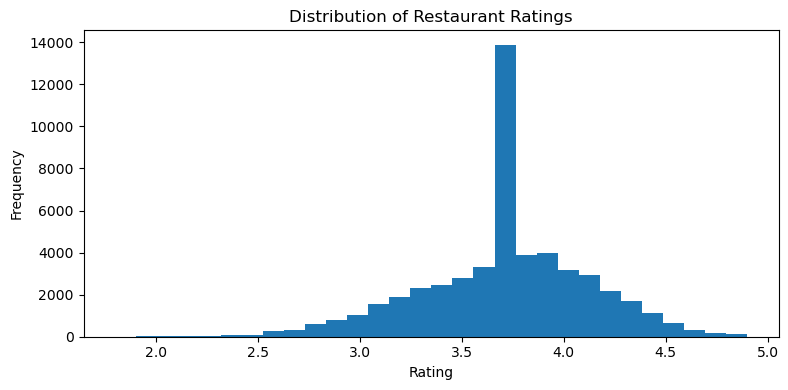

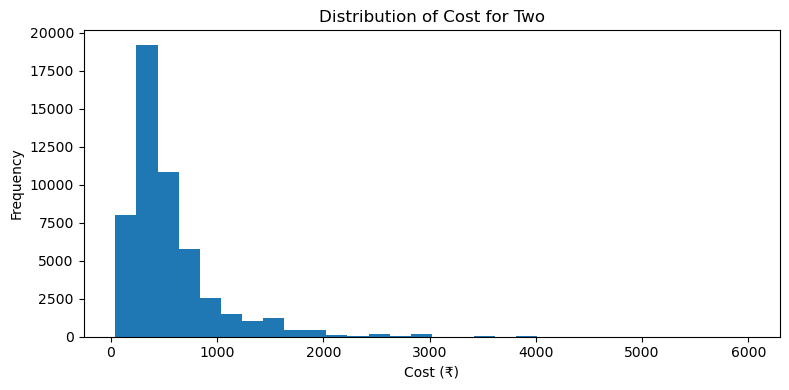

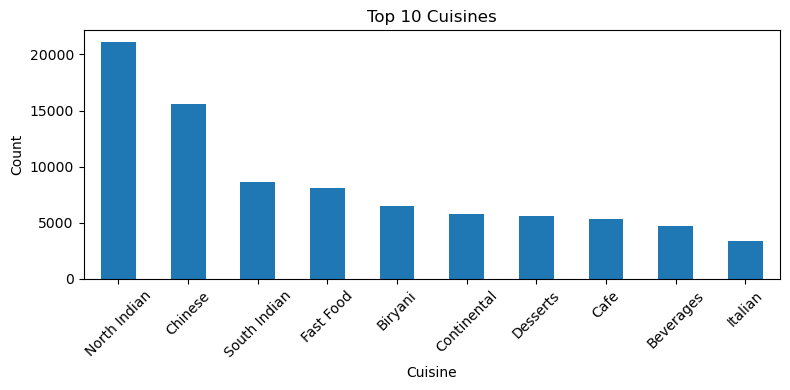

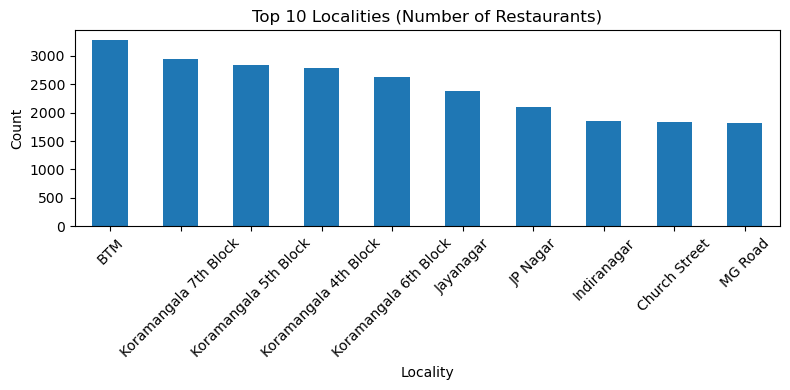

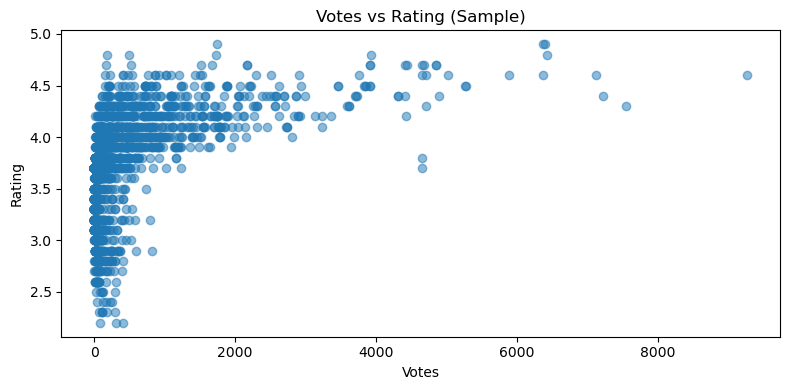

In [104]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned merged data
df = pd.read_csv('merged_cleaned.csv')

# 1) Rating distribution
plt.figure(figsize=(8,4))
df['rate'].plot(kind='hist', bins=30)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('eda_rating_distribution.png')
plt.show()

# 2) Cost for two distribution
plt.figure(figsize=(8,4))
df['approx_costfor_two_people'].plot(kind='hist', bins=30)
plt.title('Distribution of Cost for Two')
plt.xlabel('Cost (₹)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('eda_cost_distribution.png')
plt.show()

# 3) Top 10 cuisines (primary cuisine)
all_cuis = []
for x in df['cuisines'].dropna():
    all_cuis += [c.strip() for c in x.split(',')]
cuisine_counts = pd.Series(all_cuis).value_counts().head(10)

plt.figure(figsize=(8,4))
cuisine_counts.plot(kind='bar')
plt.title('Top 10 Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('eda_top10_cuisines.png')
plt.show()

# 4) Top 10 localities
loc_counts = df['listed_incity'].value_counts().head(10)
plt.figure(figsize=(8,4))
loc_counts.plot(kind='bar')
plt.title('Top 10 Localities (Number of Restaurants)')
plt.xlabel('Locality')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('eda_top10_localities.png')
plt.show()

# 5) Votes vs Rating scatter (sample)
sample_df = df.sample(frac=0.07, random_state=42)
plt.figure(figsize=(8,4))
plt.scatter(sample_df['votes'], sample_df['rate'], alpha=0.5)
plt.title('Votes vs Rating (Sample)')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.tight_layout()
plt.savefig('eda_votes_vs_rating.png')
plt.show()


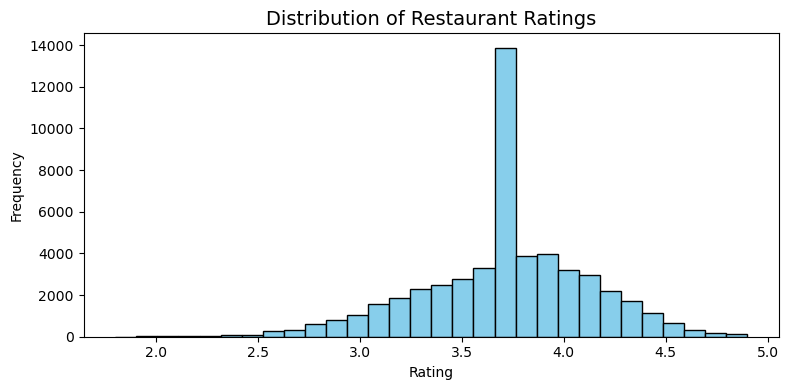

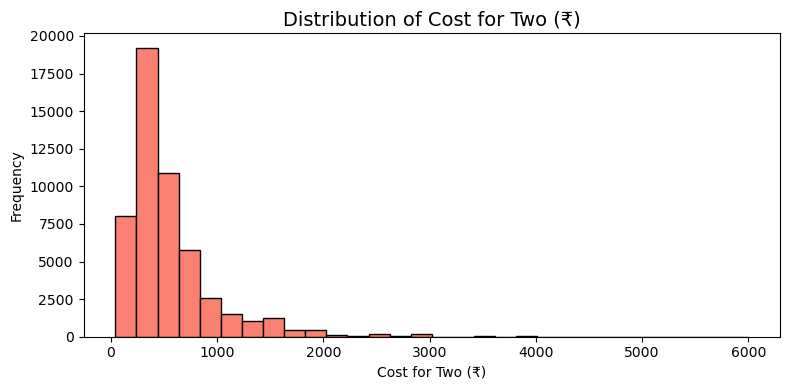

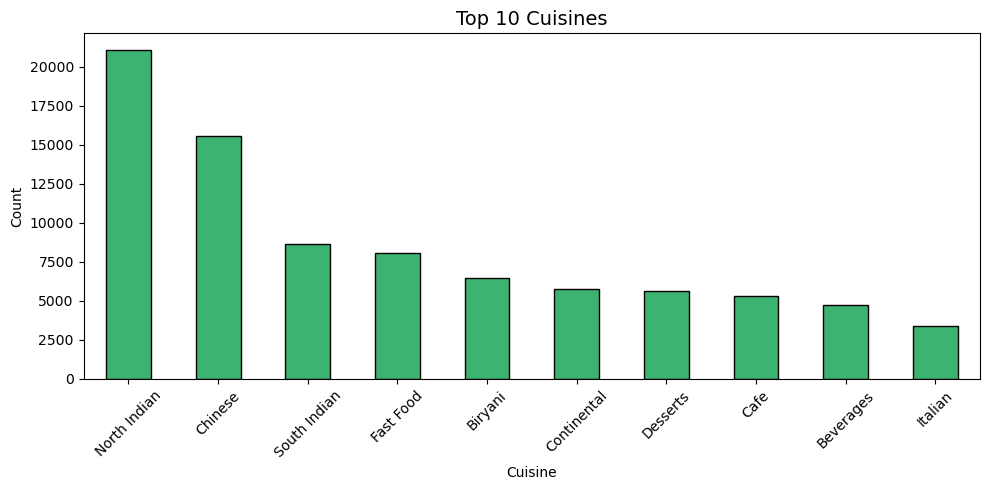

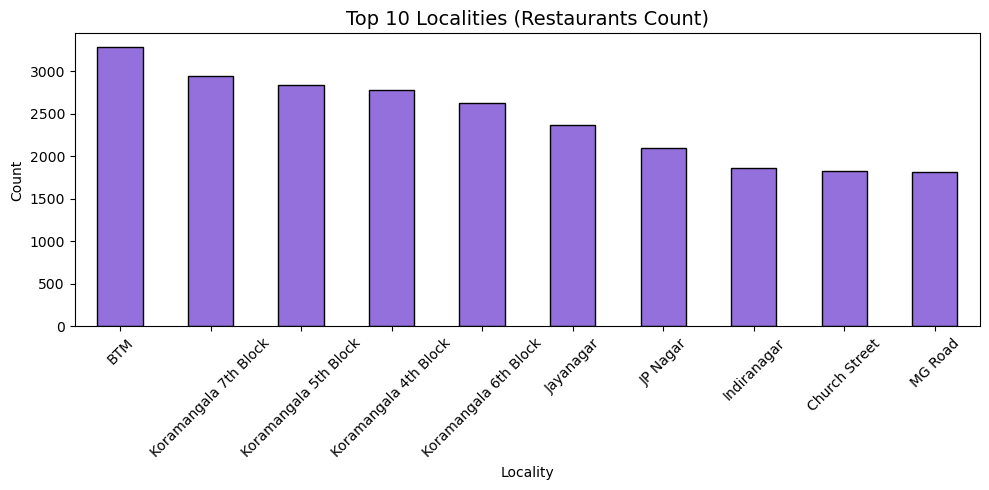

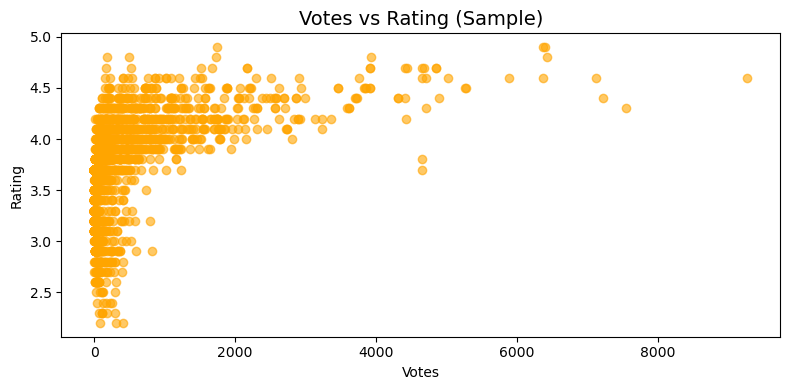

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("merged_cleaned.csv")

# ============================================================
# 1. Rating Distribution (Colored)
# ============================================================
plt.figure(figsize=(8,4))
df['rate'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Restaurant Ratings", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("colored_rating_distribution.png")
plt.show()

# ============================================================
# 2. Cost for Two Distribution (Colored)
# ============================================================
plt.figure(figsize=(8,4))
df['approx_costfor_two_people'].plot(kind='hist', bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Cost for Two (₹)", fontsize=14)
plt.xlabel("Cost for Two (₹)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("colored_cost_distribution.png")
plt.show()

# ============================================================
# 3. Top 10 Cuisines (Colored Bar Chart)
# ============================================================
all_cuisines = []
for x in df['cuisines'].dropna():
    all_cuisines += [c.strip() for c in x.split(',')]

top10_cuisines = pd.Series(all_cuisines).value_counts().head(10)

plt.figure(figsize=(10,5))
top10_cuisines.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title("Top 10 Cuisines", fontsize=14)
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("colored_top10_cuisines.png")
plt.show()

# ============================================================
# 4. Top 10 Localities (Colored Bar Chart)
# ============================================================
top10_localities = df['listed_incity'].value_counts().head(10)

plt.figure(figsize=(10,5))
top10_localities.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title("Top 10 Localities (Restaurants Count)", fontsize=14)
plt.xlabel("Locality")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("colored_top10_localities.png")
plt.show()

# ============================================================
# 5. Votes vs Rating Scatter Plot (Colored)
# ============================================================
sample_df = df.sample(frac=0.07, random_state=42)

plt.figure(figsize=(8,4))
plt.scatter(sample_df['votes'], sample_df['rate'], color='orange', alpha=0.6)
plt.title("Votes vs Rating (Sample)", fontsize=14)
plt.xlabel("Votes")
plt.ylabel("Rating")
plt.tight_layout()
plt.savefig("colored_votes_vs_rating.png")
plt.show()


# Findings

## Rating distribution: Most restaurants have ratings between 3.0 and 4.2, indicating a competitive market with clustered mid-to-high quality.

## Cost distribution: Majority of restaurants fall within ₹200–₹600; suggests affordability and a large value-seeking customer base.

## Top cuisines: Predominant cuisines include North Indian, South Indian, Chinese, Biryani, Bakery/Desserts.

## Top localities: High restaurant density in Koramangala (multiple blocks), Indiranagar, Whitefield, HSR, Marathahalli.

## Quality vs popularity: Higher-rated restaurants often have higher vote counts, indicating that popular places tend to maintain quality.

## Profitability proxy: Using cost × votes, MG Road and Church Street rank highest — attractive for premium partnerships.

## Complaints focus: Dessert Parlor, Kiosk and Bakery, Food Court types show lower average ratings — consider targeted quality audits.

## Expansion target: BTM shows the highest restaurant-type diversity (many types), good for diversified expansion and category testing.

## Top quality+demand areas: Localities like Koramangala 7th Block, MG Road, Church Street score highly on combined criteria (high rating, many votes, online orders).